# **PREDICTING HOUSE PRICES**

**In this notebook, we are going to build a machine learning model that predicts prices of houses based on historical data.**

## Data: ##
The dataset we're gonna work with is the Ames Housing dataset. It contains 80 attributes for 2,930 properties in Ames, Iowa and was completed in 2011. The attributes include number and type of rooms, location specific data and special features of the property (pool, fireplace etc.). Each row in the dataset represents a single house.

## Goal: ##
Predict sale price of a house as accurately as possible, based on data about the house features and location.

## Models: ##


## Evaluation: ##


## Result: ##



Let's take a look at our training data:

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime
import random
import warnings
from scipy import stats

# DATA #

In [34]:

# Import train and test data
house_train = pd.read_csv("./data/train.csv")
house_test = pd.read_csv("./data/test.csv")

In [35]:
# Take a look at the first 5 rows of the training data
house_train.head()


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [36]:
house_test.head()


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [37]:
# Take a look at additional info regarding the training data
house_data.info()

NameError: name 'house_data' is not defined

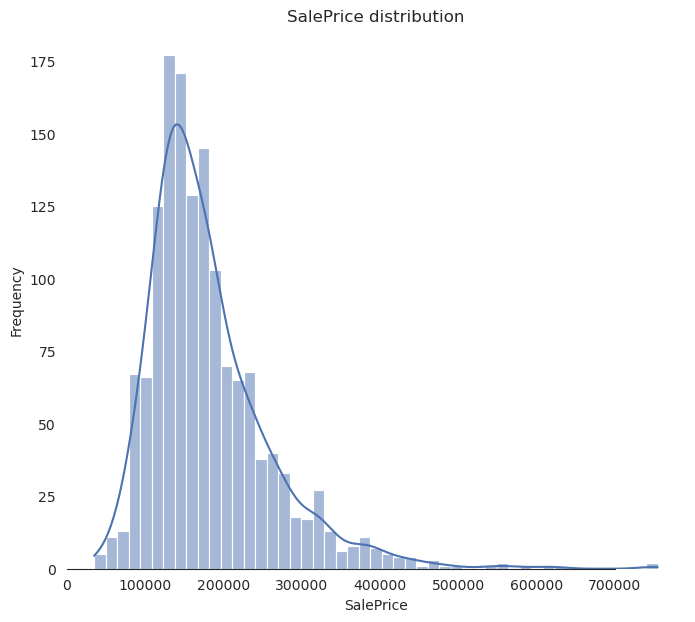

In [38]:
# Plot a histogram of the target column (SalePrice)
sns.set_style("white")
sns.set_color_codes(palette = "deep")
fig, ax = plt.subplots(figsize = [8, 7])
sns.histplot(house_train["SalePrice"], kde = "True", color = "b") # kde: Kernel Density Estimate
                                                                  # not using displot because that's a figure-level function
ax.xaxis.grid(False)
ax.set(ylabel = "Frequency")
ax.set(xlabel = "SalePrice")
ax.set(title = "SalePrice distribution")
sns.despine(trim = True, left = True)
plt.show()


In [39]:
# Look at how spread out and symmetric the graph is
print("Kurtosis: %f" % house_train["SalePrice"].kurt())
print("Skewness: %f" % house_train["SalePrice"].skew())

Kurtosis: 6.536282
Skewness: 1.882876



The kurtosis and skewness values tell us that the distribution has a pretty sharp peak and that it is "leaning" to the left, i. e., there is a high number of cheaper houses and there are a few extremely expensive ones.


Now, let's look at the features. Start by getting to know numeric features.



In [40]:
# Filter numeric features
numeric_datatypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_cols = []
for i in house_train.columns:
    if house_train[i].dtype in numeric_datatypes:
        if i in ['TotalSF', 'Total_Bathrooms','Total_porch_sf','haspool','hasgarage','hasbsmt','hasfireplace']:
            pass
        else:
            numeric_cols.append(i)     

Now, let's look at the correlation between features of the houses and the sale price. To do this, we plot the distribution of the numeric data. Data points far away from the rest are called outliers and make predictions harder.

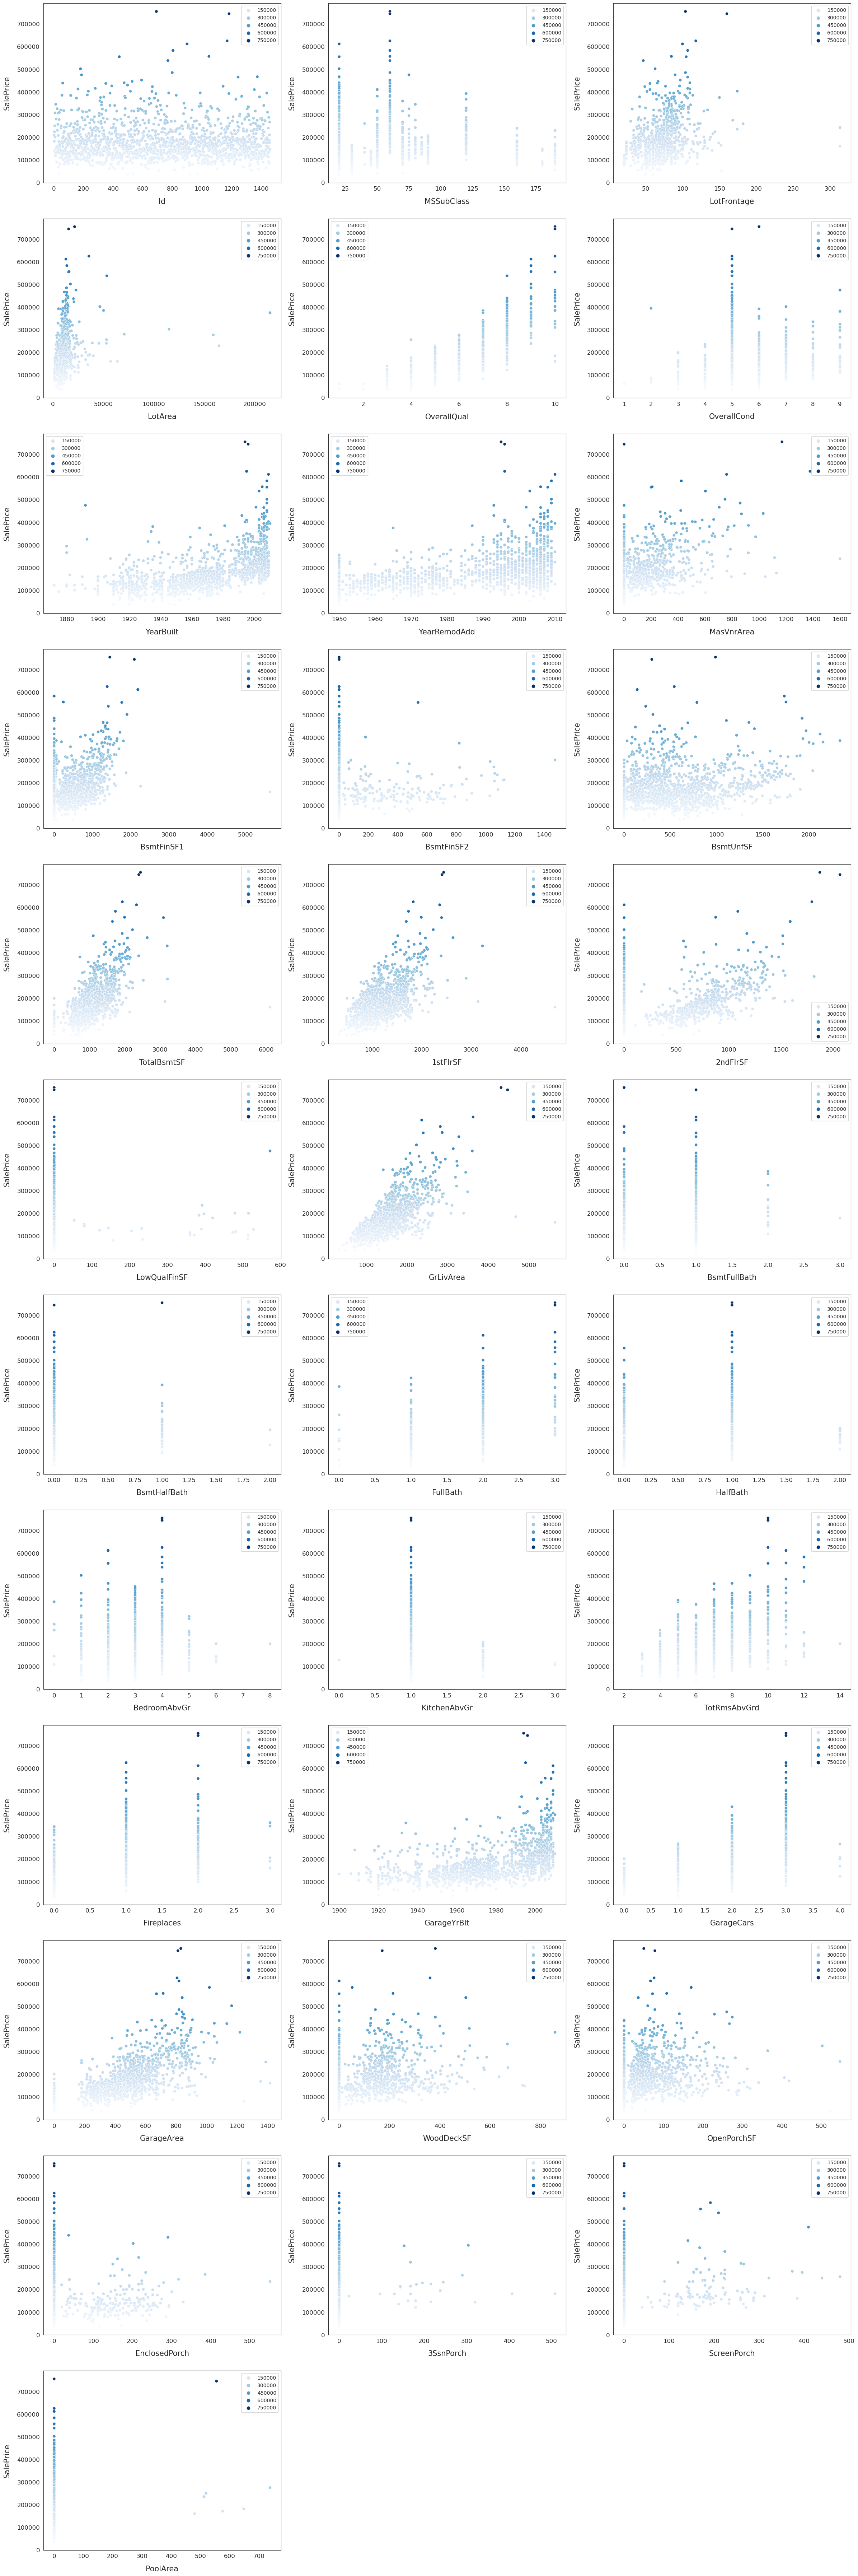

In [41]:
# Plot numeric data

fig, ax = plt.subplots(ncols = 2, nrows = 1, figsize = (12, 120))
plt.subplots_adjust(right = 2)
plt.subplots_adjust(top = 2)
sns.color_palette("husl", 8)
for i, feature in enumerate(list(house_train[numeric_cols]), 1):
    if(feature == "MiscVal"):
        break
    plt.subplot(len(list(numeric_cols)), 3, i)
    sns.scatterplot(x = feature, y = "SalePrice", hue = "SalePrice", palette = "Blues", data = house_train)
        
    plt.xlabel("{}".format(feature), size = 15,labelpad = 12.5)
    plt.ylabel("SalePrice", size = 15, labelpad = 12.5)
    
    for j in range(2):
        plt.tick_params(axis = "x", labelsize = 12)
        plt.tick_params(axis = "y", labelsize = 12)
    
    plt.legend(loc = "best", prop = {"size": 10})
        
plt.show()

Let's analyze this topic also through a correlation matrix.

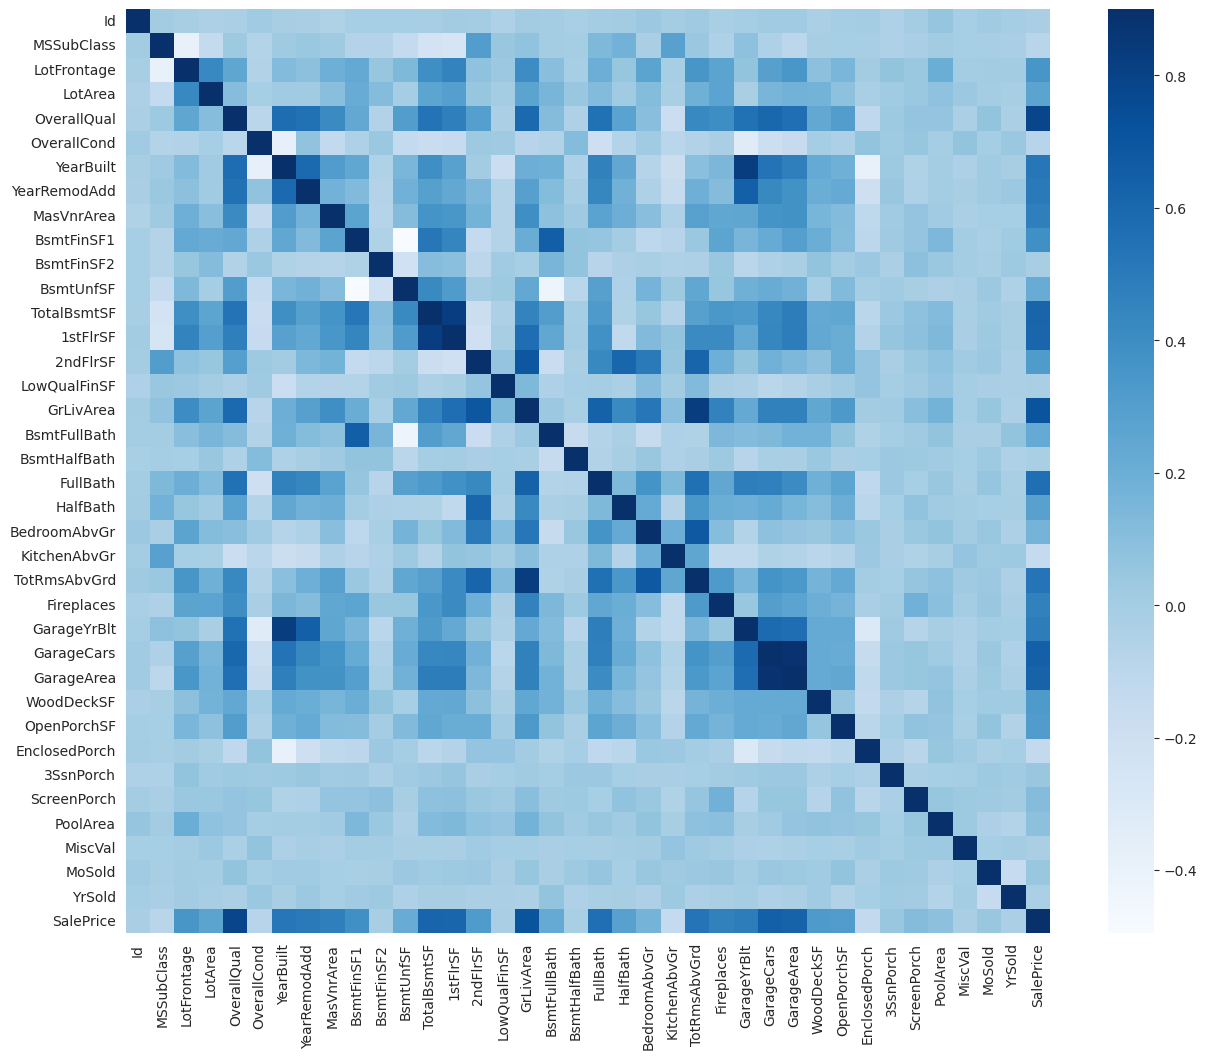

In [42]:
corr_matrix = house_train.corr()
plt.subplots(figsize = (15, 12))
sns.heatmap(corr_matrix, vmax = 0.9, cmap = "Blues", square = True);

We can see that the feature that correlates the strongest with the sale price is overall quality, which shouldn't come as a surprise. The second most influental on the sale price is the gross living area, which is also something we could suspect.

Let's analyze strongly correlating features more closely.

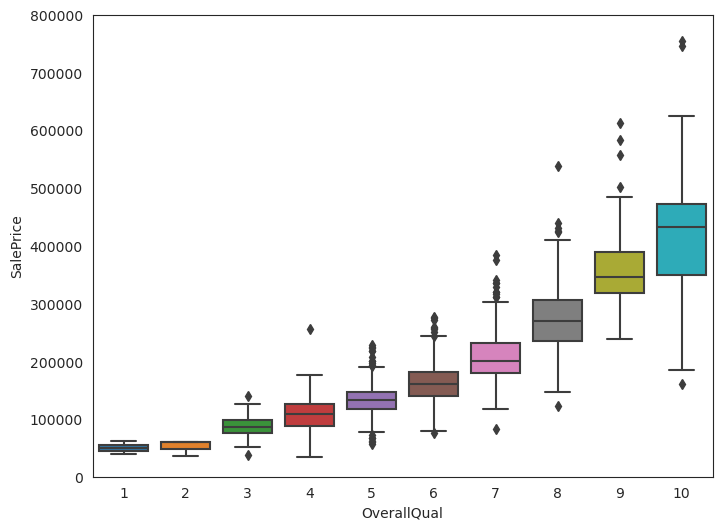

In [43]:
data = pd.concat([house_train["SalePrice"], house_train["OverallQual"]], axis = 1)
f, ax = plt.subplots(figsize = (8, 6))
fig = sns.boxplot(x = house_train["OverallQual"], y = house_train["SalePrice"], data = data)
fig.axis(ymin = 0, ymax = 800000);

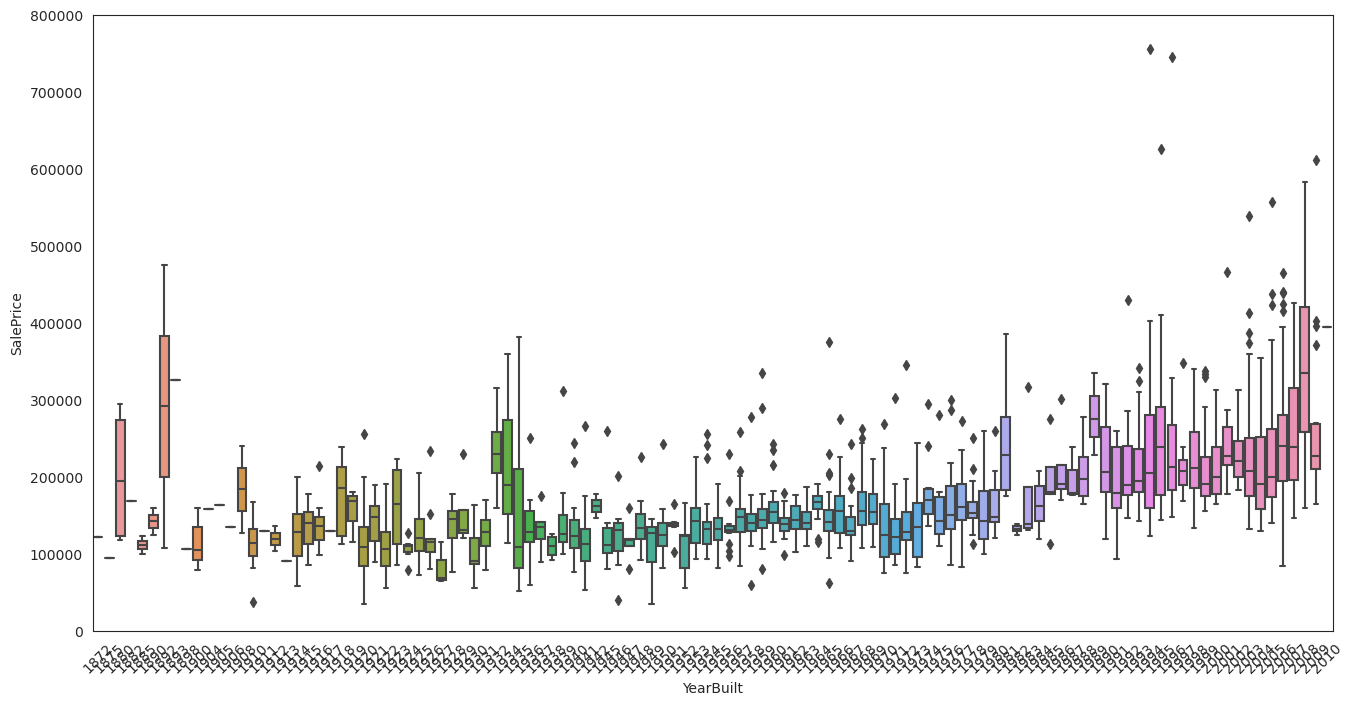

In [44]:
data = pd.concat([house_train["SalePrice"], house_train["YearBuilt"]], axis = 1)
f, ax = plt.subplots(figsize = (16, 8))
fig = sns.boxplot(x = house_train["YearBuilt"], y = house_train["SalePrice"], data = data)
fig.axis(ymin = 0, ymax = 800000)
plt.xticks(rotation = 45);



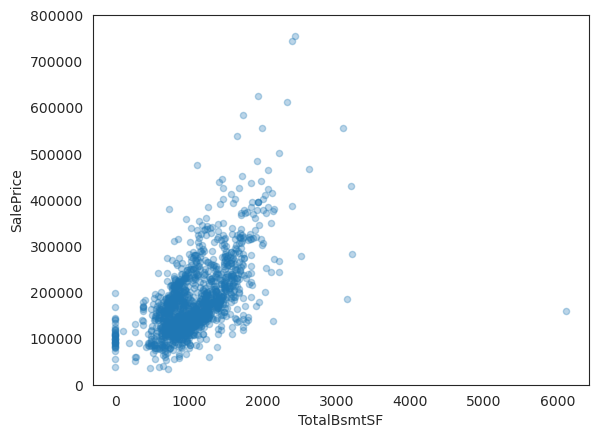

In [45]:
data = pd.concat([house_train["SalePrice"], house_train["TotalBsmtSF"]], axis = 1)
data.plot.scatter(x = "TotalBsmtSF", y = "SalePrice", alpha = 0.3, ylim = (0, 800000));

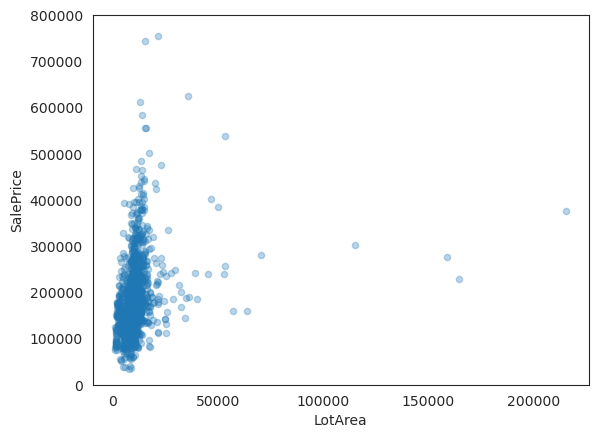

In [46]:
data = pd.concat([house_train["SalePrice"], house_train["LotArea"]], axis = 1)
data.plot.scatter(x = "LotArea", y = "SalePrice", alpha = 0.3, ylim = (0, 800000));

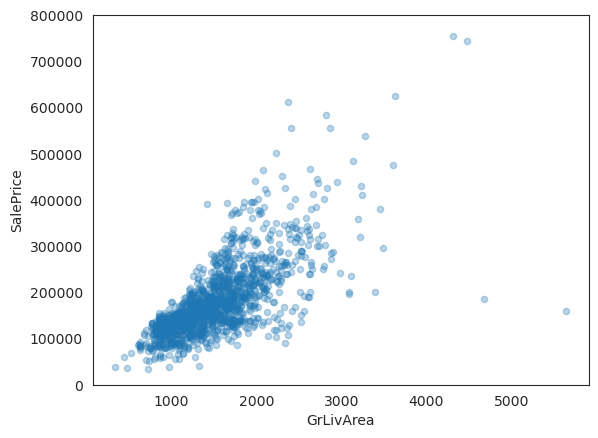

In [47]:
data = pd.concat([house_train["SalePrice"], house_train["GrLivArea"]], axis = 1)
data.plot.scatter(x = "GrLivArea", y = "SalePrice", alpha = 0.3, ylim = (0, 800000));

Now, let's prepare our data for model training.
First, we need to remove the IDs as we won't be using them to train our models.

In [48]:
house_train.reset_index(drop = True, inplace = True)
house_test.reset_index(drop = True, inplace = True)
house_train.shape, house_test.shape


((1460, 81), (1459, 80))

## Feature Engineering

Now it's time to do some feature engineering. Let's look again at the plot of the target column (sale price).

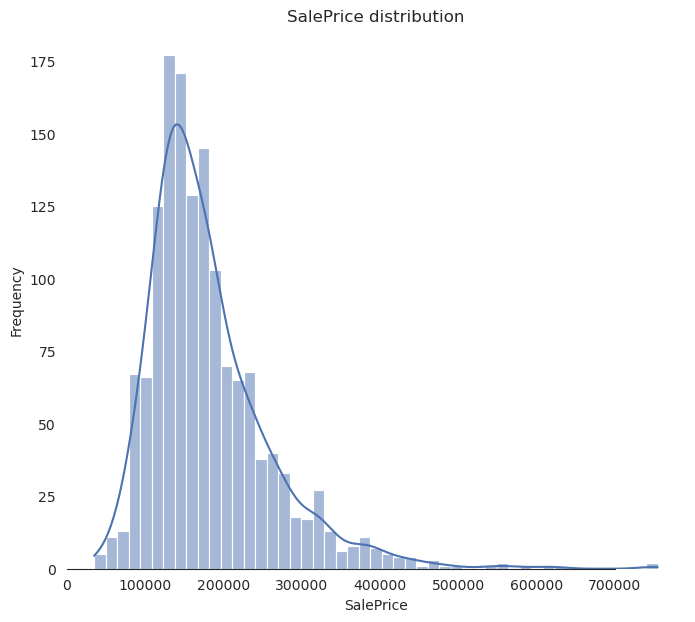

In [49]:
sns.set_style("white")
sns.set_color_codes(palette = "deep")
fig, ax = plt.subplots(figsize = (8, 7))
sns.histplot(house_train["SalePrice"], color = "b", kde = True);
ax.xaxis.grid(False)
ax.set(ylabel = "Frequency")
ax.set(xlabel = "SalePrice")
ax.set(title = "SalePrice distribution")
sns.despine(trim = True, left = True)
plt.show()

As we can see from the image above, the sale price graph is positively skewed. This can be a problem as most machine learning models don't do well on normal distributions with significant skew.
To change this, we can take the logarithm of the sale price.

In [50]:
house_train["SalePrice"] = np.log1p(house_train["SalePrice"])

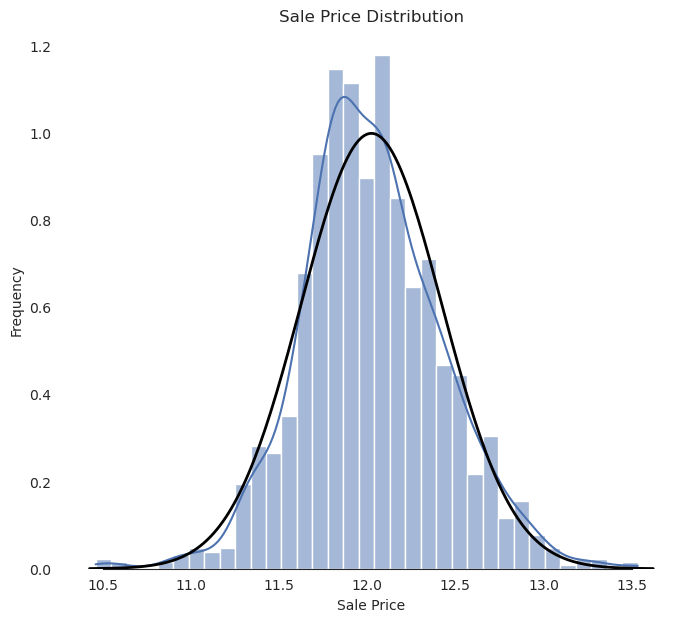

In [51]:
# Define function to plot a normal distribution

def normal(mean, std, color = "black"):
    x = np.linspace(mean - 4 * std, mean + 4 * std, 200)
    p = stats.norm.pdf(x, mean, std)
    z = plt.plot(x, p, color, linewidth = 2)

sns.set_style("white")
sns.set_color_codes(palette = "deep")
fig, ax = plt.subplots(figsize = (8, 7))
sns.histplot(house_train["SalePrice"], stat = "density", color = "b", kde = True)
ax.xaxis.grid(False)
ax.set(xlabel = "Sale Price", ylabel = "Frequency", title = "Sale Price Distribution")
sns.despine(trim = True, left = True)

# Plot normal distribution with no skew or kurtosis
normal(house_train["SalePrice"].mean(), house_train["SalePrice"].std())

plt.show();

In the next step, we're gonna remove outliers. These are single data points far away from the rest of the data and are therefore not representative for the dataset as a whole.

In [52]:
house_train.drop(house_train[(house_train['OverallQual'] < 5) & (house_train['SalePrice'] > 200000)].index, inplace = True)
house_train.drop(house_train[(house_train['GrLivArea'] > 4500) & (house_train['SalePrice'] < 300000)].index, inplace = True)
house_train.reset_index(drop = True, inplace = True)

In [53]:
# Create labels and features containers
house_train_labels = house_train['SalePrice'].reset_index(drop = True)
house_train_features = house_train.drop(['SalePrice'], axis = 1)
house_test_features = house_test

# Combine train and test features in order to apply the feature transformation pipeline to the entire dataset
all_features = pd.concat([house_train_features, house_test_features]).reset_index(drop = True)
all_features.shape

(2917, 80)

We're now gonna fill in gaps in the data with appropriate values.

In [54]:
# Determine fraction of missing values
def missingCalc(df):
    data = pd.DataFrame(df)
    df_cols = list(pd.DataFrame(data))
    missing_fractions = {}
    for i in range(len(df_cols)):
        missing_fractions.update({df_cols[i]: round(data[df_cols[i]].isnull().mean()*100,2)})
    
    return missing_fractions

missing = missingCalc(all_features)
df_miss = sorted(missing.items(), key = lambda x: x[1], reverse = True)
print("Percentage of missing data")
df_miss[:10]



Percentage of missing data


[('PoolQC', 99.69),
 ('MiscFeature', 96.4),
 ('Alley', 93.21),
 ('Fence', 80.43),
 ('FireplaceQu', 48.68),
 ('LotFrontage', 16.66),
 ('GarageYrBlt', 5.45),
 ('GarageFinish', 5.45),
 ('GarageQual', 5.45),
 ('GarageCond', 5.45)]

There's quite a lot missing data. Let's visualize that.

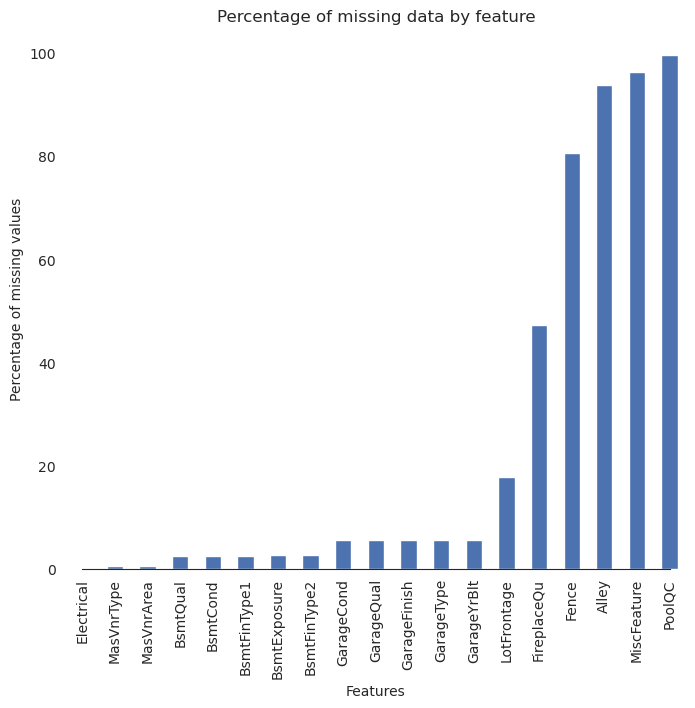

In [55]:
# Visualize missing values
sns.set_style("white")
sns.set_color_codes(palette = "deep")
fig, ax = plt.subplots(figsize = (8, 7))
missing = round(house_train.isnull().mean() * 100,2)
missing = missing[missing > 0]
missing.sort_values(inplace = True)
missing.plot.bar(color = "b")
ax.xaxis.grid(False)
ax.set(ylabel = "Percentage of missing values")
ax.set(xlabel = "Features")
ax.set(title = "Percentage of missing data by feature")
sns.despine(trim = True, left = True)

We're now gonna fill the gaps in the data with suitable values. This helps the machine learning model to make more accurate predictions.

In [56]:
# Convert non-numeric columns that store values as numbers to strings
all_features["MSSubClass"] = all_features["MSSubClass"].apply(str)
all_features["YrSold"] = all_features["YrSold"].astype(str)
all_features["MoSold"] = all_features["MoSold"].astype(str)

Let's define a function to fill missing values in data.

In [57]:

def fillMissingData(features):
    
    # The data description states that "NA" refers to typical ("Typ") values
    features["Functional"] = features["Functional"].fillna("Typ")

    # Replace the missing values in each of the columns below with their mode
    features["Electrical"] = features["Electrical"].fillna("SBrkr")
    features["KitchenQual"] = features["KitchenQual"].fillna("TA")
    features["Exterior1st"] = features["Exterior1st"].fillna(features["Exterior1st"].mode()[0])
    features["Exterior2nd"] = features["Exterior2nd"].fillna(features["Exterior2nd"].mode()[0])
    features["SaleType"] = features["SaleType"].fillna(features["SaleType"].mode()[0])
    features["MSZoning"] = features.groupby("MSSubClass")["MSZoning"].transform(lambda x: x.fillna(x.mode()[0]))

    # The data description states that "NA" refers to "No Pool"
    features["PoolQC"] = features["PoolQC"].fillna("None")

    # Replacing the missing values with 0, since no garage = no cars in garage
    for col in ("GarageYrBlt", "GarageArea", "GarageCars"):
        features[col] = features[col].fillna(0)

    # Replacing the missing values with "None"
    for col in ["GarageType", "GarageFinish", "GarageQual", "GarageCond"]:
        features[col] = features[col].fillna("None")

    # "NaN" values for these categorical basement features mean there's no basement
    for col in ("BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2"):
        features[col] = features[col].fillna("None")
        
    # Group features by neighborhood, and fill missing value by the median LotFrontage of the neighborhood
    features["LotFrontage"] = features.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

    # For the missing values in the rest of the categorical features, there's not enough information to fill them properly, so they're filled with "None"
    objects = []
    for i in features.columns:
        if features[i].dtype == object:
            objects.append(i)
    features.update(features[objects].fillna("None"))
        
    # The same is true for the numerical features, so the gaps are filled with zeros
    numeric_dtypes = ["int16", "int32", "int64", "float16", "float32", "float64"]
    numeric = []
    for i in features.columns:
        if features[i].dtype in numeric_dtypes:
            numeric.append(i)
    features.update(features[numeric].fillna(0))    
    return features

all_features = fillMissingData(all_features)


In [59]:
# Check if we handled all the missing values
missing = missingCalc(all_features)
missing_sorted = sorted(missing.items(), key = lambda x: x[1], reverse = True)
print("Percentage of missing data")
missing_sorted[:10]


Percentage of missing data


[('Id', 0.0),
 ('MSSubClass', 0.0),
 ('MSZoning', 0.0),
 ('LotFrontage', 0.0),
 ('LotArea', 0.0),
 ('Street', 0.0),
 ('Alley', 0.0),
 ('LotShape', 0.0),
 ('LandContour', 0.0),
 ('Utilities', 0.0)]

We can see that there are no more missing values, so we can move on to the next step: fixing skewed features.